In [1]:
!pip install xgboost==0.90
import xgboost
xgboost.__version__

'0.90'

In [2]:
!pip uninstall -y watson-machine-learning-client-V4
!pip install -U watson-machine-learning-client-V4 | tail -n 1
!pip install -U autoai-libs | tail -n 1
!pip show watson-machine-learning-client-V4
!pip install lightgbm


Uninstalling watson-machine-learning-client-V4-1.0.109:
  Successfully uninstalled watson-machine-learning-client-V4-1.0.109
Name: watson-machine-learning-client-V4
Version: 1.0.109
Summary: Watson Machine Learning API Client
Home-page: http://wml-api-pyclient-v4.mybluemix.net
Author: IBM
Author-email: svagaral@in.ibm.com, nagiredd@in.ibm.com, amadeusz.masny1@ibm.com
License: BSD
Location: /opt/conda/envs/Python36/lib/python3.6/site-packages
Requires: certifi, lomond, urllib3, ibm-cos-sdk, tabulate, requests, pandas
Required-by: 


In [3]:
!pip install spacy
!pip install pyresparser
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_sm

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [4]:
from ibmdbpy import IdaDataBase, IdaDataFrame
import pandas as pd
from project_lib import Project
import pandas as pd
import numpy as np
from watson_machine_learning_client.experiment import AutoAI
from watson_machine_learning_client.deployment import WebService
from watson_machine_learning_client.helpers import DataConnection, S3Connection, S3Location

In [5]:
import string
import csv
import re
import sys
import importlib
import os
import spacy
import nltk
from spacy.matcher import matcher
import multiprocessing as mp
import requests
nltk.download('stopwords')
from pyresparser import ResumeParser

In [6]:
idadbjpd= IdaDataBase(dsn= "DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-dal09-10.services.dal.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=vnp85352;PWD=5lfnsbt9j-7lgph7")
idadbp1=IdaDataBase(dsn="DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-lon02-07.services.eu-gb.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=rvq84761;PWD=lgd7h7-xzmjtlf2m;")
idadbp2=IdaDataBase(dsn="DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-lon02-07.services.eu-gb.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=zsw28431;PWD=x4x1nrpq3^823zgv;")
idadbp3=IdaDataBase(dsn="DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-lon02-07.services.eu-gb.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=xmf82991;PWD=n@6qf514mw4h5n38;")
idadbcd=IdaDataBase(dsn="DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-lon02-06.services.eu-gb.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=kbc37254;PWD=fg8vn6z-6mv015d3;")
idadbcd2=IdaDataBase(dsn= "DASHDB;DATABASE=BLUDB;HOSTNAME=dashdb-txn-sbox-yp-lon02-07.services.eu-gb.bluemix.net;PORT=50000;PROTOCOL=TCPIP;UID=wmg78134;PWD=29hncd^qrjkrvf5b;")

In [7]:
def close_all_connections():
    idadbjpd.close()
    idadbp1.close()
    idadbp2.close()
    idadbcd.close()
    idadbcd2.close()

In [8]:
#close_all_connections()

In [9]:
def commit_all():
    idadbjpd.commit()
    idadbp1.commit()
    idadbp2.commit()
    idadbp3.commit()
    idadbcd.commit()

In [10]:
#commit_all()

In [11]:
def clear_all_tables():
    idadbjpd.ida_query("delete  From job_post_data")
    idadbcd.ida_query("delete  From candidate_data")
    idadbcd2.ida_query("delete  From candidate_data")
    idadbp3.ida_query("delete  From phase_3")
    idadbp2.ida_query("delete  From phase_2")
    idadbp1.ida_query("delete  From phase_1")

In [12]:
#clear_all_tables()

In [13]:
def check_db():
    temp=idadbp2.ida_query("select count(*) FROM PHASE_2 where trained_status='nottrained' FETCH FIRST 1 ROWS ONLY")
    return temp[0]

In [14]:
def check_candidate_db():
    temp=idadbcd.ida_query("select count(*) FROM CANDIDATE_DATA where VISITED='notvisited' FETCH FIRST 1 ROWS ONLY")
    return temp[0] 

In [15]:
#taken from this StackOverflow answer: https://stackoverflow.com/a/39225039
def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"
    session = requests.Session()
    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)
    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)
    save_response_content(response, destination)    
def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value
    return None
def save_response_content(response, destination):
    CHUNK_SIZE = 32768
    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [16]:
def trainmodel():
    #idadb.reconnect()
    temp=idadbp2.ida_query("SELECT cid FROM PHASE_2 where trained_status='nottrained' FETCH FIRST 1 ROWS ONLY")
    untrained_company=temp[0]
    filename=untrained_company
    cn=untrained_company.lower()
    print("Training Company ID:",cn)
    training_df = pd.read_csv("https://ibmhctrail.s3.eu-gb.cloud-object-storage.appdomain.cloud/"+filename)
    print("Training Data:")
    print(training_df)
    project = Project(project_id='b43dc68b-a702-442c-b23c-40f7167587ae', project_access_token='p-d533ba6af096afd9b3c393749c994358bffa692a')
    pc = project.project_context
    wml_credentials ={
  "apikey": "NFXwyjC6sEam_B36OTgJiWe2csn7E6cjqrVDotKhLj5p",
  "iam_apikey_description": "Auto-generated for key b13302d5-b476-48e0-976a-c4258cdcab94",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/9df68aabc42a450fbb0849747805cee0::serviceid:ServiceId-8d5abc6b-b354-4139-b328-1c4f3bbd8428",
  "instance_id": "646664dd-422a-45f9-93e6-6443074c79d5",
  "url": "https://us-south.ml.cloud.ibm.com"
}
    print("Project Context Details:",pc)
    csv_details = project.save_data(data=training_df.to_csv(index=False),file_name='temp.csv',overwrite=True)
    print("Instantiating a Temporary dataset")
    print(csv_details)
    storage_meta = project.get_storage_metadata()
    filename = csv_details['file_name']
    bucket_name = csv_details['bucket_name']
    credit_risk_conn = DataConnection(
    connection=S3Connection(endpoint_url=storage_meta['properties']['endpoint_url'],
                            access_key_id=storage_meta['properties']['credentials']['editor']['access_key_id'],
                            secret_access_key=storage_meta['properties']['credentials']['editor']['secret_access_key']),
    location=S3Location(bucket=bucket_name,
                        path=filename))

    training_data_reference=[credit_risk_conn]
    experiment = AutoAI(wml_credentials)
    pipeline_optimizer = experiment.optimizer(
    name='candidate_shortlisting_predictor - AutoAI',
    prediction_type='classification',
    daub_include_only_estimators=[AutoAI.ClassificationAlgorithms.LGBM, AutoAI.ClassificationAlgorithms.XGB],
    prediction_column='satisfied',#df[df.columns[-1]]
    scoring=AutoAI.Metrics.R2_SCORE,)
    print(pipeline_optimizer.get_params())
    run_details = pipeline_optimizer.fit(
            training_data_reference=training_data_reference,
            background_mode=False)
    #print("Run Details:")
    #print(run_details)
    summary = pipeline_optimizer.summary()
    print("Pipeline Summary:")
    print(summary)
    best_pipeline = pipeline_optimizer.get_pipeline()#Since we haven't passed any pipeline name as parameter, it automatically chooses the best_pipeline
    best_pipeline.visualize()
    best_pipeline.pretty_print(ipython_display=True)
    service = WebService(wml_credentials)
    service.create(
    experiment_run_id=pipeline_optimizer._engine._current_run_id,
    model=best_pipeline, 
    deployment_name="Shortlist Predictor AutoAI WebService")
    scoringurl=service.scoring_url
    print("WebService",service)
    surl=""+service.name+","+service.id+","+service.scoring_url+","+service.asset_id
    print(surl)
    colstr=""
    data=training_df
    for col in data.columns: 
        colstr+=','+col
    colstr
    colstr=colstr.lstrip(',')
    col=[]
    col=colstr.split(',')
    col.pop()
    colstr=",".join(col)
    idadbp2.ida_query("update PHASE_2 set surl='"+surl+"' where cid='"+untrained_company+"'")
    idadbp2.ida_query("update PHASE_2 set params='"+colstr+"' where cid='"+untrained_company+"'")
    idadbp2.ida_query("UPDATE PHASE_2 SET TRAINED_STATUS='Trained' WHERE CID='"+cn+"' ")
    idadbp2.commit()
    return
    

In [17]:
def check_eligibility():
    data=idadbcd.ida_query("SELECT RESUMELINK,APID FROM CANDIDATE_DATA where VISITED='notvisited'")
    file_id=data['resumelink'][0]
    file_id=file_id.replace('/view?usp=sharing',"")
    file_id=file_id.replace('https://drive.google.com/file/d/','')
    apid=data['apid'][0]
    destination = 'temp.pdf'
    download_file_from_google_drive(file_id, destination)
    data = ResumeParser('temp.pdf').get_extracted_data()
    name=data['name']
    email=data['email']
    mbl=data['mobile_number']
    skills=data['skills']
    exp=data['experience']
    totalexp=data['total_experience']
    print("Candidate Name:",name)
    print("Candidate Email:",email)
    print("Candidate Mobile Number:",mbl)
    print("Candidate Skills:",','.join(skills))
    print("Candidate Experiences:",exp)
    print("Candidate Total Experience:",totalexp)
    print("Candidate Application Id:",apid)
    idadbcd.ida_query("UPDATE CANDIDATE_DATA SET MAILID ='"+email+"',NAME='"+name+"',MBLNO='"+str(mbl)+"',SKILLS='"+','.join(skills)+"',exp='"+str(totalexp)+"',visited='visited' where APID='"+apid+"';")
    cidn=idadbcd.ida_query("select cid from CANDIDATE_DATA where APID='"+apid+"';")
    print("Applied Company:",cidn[0])
    cidn=cidn[0]
    surl=idadbp2.ida_query("select surl from PHASE_2 where cid='"+cidn+"'  FETCH FIRST 1 ROWS ONLY")
    print("Web Service Details:",surl[0])
    type(surl[0])
    params=idadbp2.ida_query("select params from PHASE_2 where cid='"+cidn+"'  FETCH FIRST 1 ROWS ONLY")
    params=params[0]
    print("Required Parameters For the company:",params)
    testdata=idadbcd.ida_query("select "+params+" from CANDIDATE_DATA where APID='"+apid+"';")
    print(testdata)
    from watson_machine_learning_client.deployment import WebService
    s= WebService({
  "apikey": "NFXwyjC6sEam_B36OTgJiWe2csn7E6cjqrVDotKhLj5p",
  "iam_apikey_description": "Auto-generated for key b13302d5-b476-48e0-976a-c4258cdcab94",
  "iam_apikey_name": "Service credentials-1",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/9df68aabc42a450fbb0849747805cee0::serviceid:ServiceId-8d5abc6b-b354-4139-b328-1c4f3bbd8428",
  "instance_id": "646664dd-422a-45f9-93e6-6443074c79d5",
  "url": "https://us-south.ml.cloud.ibm.com"
})
    print("Empty WebService Object",s)
    print("After Assigning trained details,")
    surl=surl[0]
    s.name=surl.split(',')[0]
    s.id=surl.split(',')[1]
    s.scoring_url=surl.split(',')[2]
    s.asset_id=surl.split(',')[3]
    print("New WebService Object",s)
    a=s.score(testdata)
    print(s.score(testdata))
    print(testdata)
    prediction=""
    if(a['predictions'][0]['values'][0][0])=="Yes":
        prediction="Selected"
    else:
        prediction="Not Selected"
    idadbcd.ida_query("update candidate_data set p2='"+prediction+"' where APID='"+apid+"';")
    idadbcd.commit()
    data=idadbcd.ida_query("SELECT * From candidate_Data")
    idadbcd2.ida_query("delete from candidate_data")
    colnames=""
    for i, val in enumerate(data): 
        colnames+=","+val
        colnames=colnames.strip(',')
        #print(colnames)
    for j in range (0,len(data)):
        strr=""
        for i in data.iloc[j] :
            strr+=",'"+i+"'"
            #strr=strr.replace(',',' ')    
        idadbcd2.ida_query("insert into Candidate_Data("+colnames+") values("+strr.strip(',')+")")
    idadbcd2.commit()
    return s.score(testdata)

No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
Still 1.0companies need to be trained
Training One Company data among 1.0
Training Company ID: a@gmail.com
Training Data:
    degree  intern  exp  percentage satisfied
0   B.Tech       0    0          75        No
1   B.Tech       1    0          76        No
2   M.Tech 

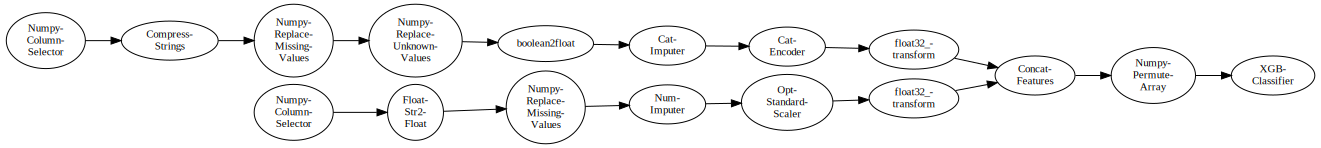

```python
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.lale import ConcatFeatures
from lale.lib.autoai_libs import NumpyPermuteArray
from xgboost import XGBClassifier
import lale
lale.wrap_imported_operators()

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 2])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['char_str', 'int_num', 'int_num'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], []])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=float('nan'), filling_values_list=[float('nan'), float('nan'), float('nan')], known_values_list=[[9537879057432856503013343767957247185, 243290441302341925281268831617389425740, 339929994502401161878329535103563083879], [0, 1, 2], [0, 1]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=float('nan'), sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
numpy_column_selector_1 = NumpyColumnSelector(columns=[3])
float_str2_float = FloatStr2Float(dtypes_list=['int_num'], missing_values_reference_list=[])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 1, 2, 3])
xgb_classifier = XGBClassifier(missing=float('nan'), random_state=33, silent=True, verbosity=0, tree_method='hist')
pipeline = ((numpy_column_selector_0 >> compress_strings >> numpy_replace_missing_values_0 >> numpy_replace_unknown_values >> boolean2float() >> cat_imputer >> cat_encoder >> float32_transform()) & (numpy_column_selector_1 >> float_str2_float >> numpy_replace_missing_values_1 >> num_imputer >> opt_standard_scaler >> float32_transform())) >> ConcatFeatures() >> numpy_permute_array >> xgb_classifier
```

Preparing an AutoAI Deployment...
Published model uid: 34a80127-bdad-4b94-8a84-9c78b8155547
Deploying model 34a80127-bdad-4b94-8a84-9c78b8155547 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '34a80127-bdad-4b94-8a84-9c78b8155547' started

#######################################################################################


initializing.....
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='9af0656a-f1a1-4a98-8839-cc0e4e3ceb7e'
------------------------------------------------------------------------------------------------


WebService name: Shortlist Predictor AutoAI WebService, id: 9af0656a-f1a1-4a98-8839-cc0e4e3ceb7e, scoring_url: https://us-south.ml.cloud.ibm.com/v4/deployments/9af0656a-f1a1-4a98-8839-cc0e4e3ceb7e/predictions, asset_id: 34a80127-bdad-4b94-8a84-9c78b

No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at t

No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at this time
No Candidate Applied for a Job at this time
No Company Posted a job at t

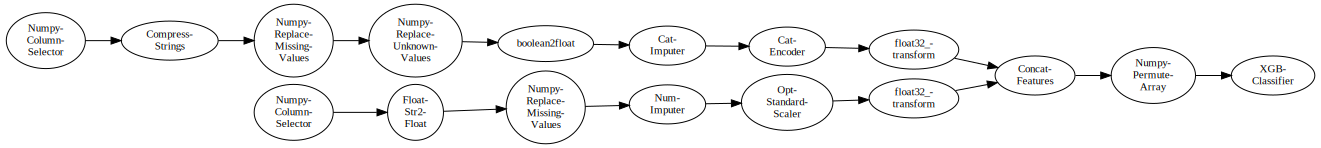

```python
from lale.lib.autoai_libs import NumpyColumnSelector
from lale.lib.autoai_libs import CompressStrings
from lale.lib.autoai_libs import NumpyReplaceMissingValues
from lale.lib.autoai_libs import NumpyReplaceUnknownValues
from lale.lib.autoai_libs import boolean2float
from lale.lib.autoai_libs import CatImputer
from lale.lib.autoai_libs import CatEncoder
import numpy as np
from lale.lib.autoai_libs import float32_transform
from lale.lib.autoai_libs import FloatStr2Float
from lale.lib.autoai_libs import NumImputer
from lale.lib.autoai_libs import OptStandardScaler
from lale.lib.lale import ConcatFeatures
from lale.lib.autoai_libs import NumpyPermuteArray
from xgboost import XGBClassifier
import lale
lale.wrap_imported_operators()

numpy_column_selector_0 = NumpyColumnSelector(columns=[0, 1, 2])
compress_strings = CompressStrings(compress_type='hash', dtypes_list=['char_str', 'int_num', 'int_num'], missing_values_reference_list=['', '-', '?', float('nan')], misslist_list=[[], [], []])
numpy_replace_missing_values_0 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
numpy_replace_unknown_values = NumpyReplaceUnknownValues(filling_values=float('nan'), filling_values_list=[float('nan'), float('nan'), float('nan')], known_values_list=[[9537879057432856503013343767957247185, 243290441302341925281268831617389425740, 339929994502401161878329535103563083879], [0, 1, 2], [0, 1]], missing_values_reference_list=['', '-', '?', float('nan')])
cat_imputer = CatImputer(missing_values=float('nan'), sklearn_version_family='20', strategy='most_frequent')
cat_encoder = CatEncoder(dtype=np.float64, handle_unknown='error', sklearn_version_family='20')
numpy_column_selector_1 = NumpyColumnSelector(columns=[3])
float_str2_float = FloatStr2Float(dtypes_list=['int_num'], missing_values_reference_list=[])
numpy_replace_missing_values_1 = NumpyReplaceMissingValues(filling_values=float('nan'), missing_values=[])
num_imputer = NumImputer(missing_values=float('nan'), strategy='median')
opt_standard_scaler = OptStandardScaler(num_scaler_copy=None, num_scaler_with_mean=None, num_scaler_with_std=None, use_scaler_flag=False)
numpy_permute_array = NumpyPermuteArray(axis=0, permutation_indices=[0, 1, 2, 3])
xgb_classifier = XGBClassifier(missing=float('nan'), random_state=33, silent=True, verbosity=0, tree_method='hist')
pipeline = ((numpy_column_selector_0 >> compress_strings >> numpy_replace_missing_values_0 >> numpy_replace_unknown_values >> boolean2float() >> cat_imputer >> cat_encoder >> float32_transform()) & (numpy_column_selector_1 >> float_str2_float >> numpy_replace_missing_values_1 >> num_imputer >> opt_standard_scaler >> float32_transform())) >> ConcatFeatures() >> numpy_permute_array >> xgb_classifier
```

Preparing an AutoAI Deployment...
Published model uid: 1c6d8154-3f0d-4ac1-8051-22ac865d0b83
Deploying model 1c6d8154-3f0d-4ac1-8051-22ac865d0b83 using V4 client.


#######################################################################################

Synchronous deployment creation for uid: '1c6d8154-3f0d-4ac1-8051-22ac865d0b83' started

#######################################################################################


initializing......
ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='aeade2bc-c553-428e-a2af-19a921121b32'
------------------------------------------------------------------------------------------------


WebService name: Shortlist Predictor AutoAI WebService, id: aeade2bc-c553-428e-a2af-19a921121b32, scoring_url: https://us-south.ml.cloud.ibm.com/v4/deployments/aeade2bc-c553-428e-a2af-19a921121b32/predictions, asset_id: 1c6d8154-3f0d-4ac1-8051-22ac

In [ ]:
from watson_machine_learning_client.deployment import WebService
import time
while True:
    count1=check_db()
    if(count1)>0:
        print("Still "+str(count1)+"companies need to be trained")
        print("Training One Company data among "+str(count1))
        trainmodel()
    else:
        print("No Company Posted a job at this time")
    count2=check_candidate_db()
    if(count2)>0:
        print("Still "+str(count2)+" candidates need to be checked")
        print("Checking One Candidate data among "+str(count2))
        a=check_eligibility()
    else:
        print("No Candidate Applied for a Job at this time")
    time.sleep(30)


In [ ]:
idadbcd2.ida_query("select * from candidate_data")


In [ ]:
commit_all()

In [ ]:
idadbcd.ida_query("ALTER TABLE candidate_data ADD COLUMN BEHAVIOURAL varchar(1000) ")

In [ ]:
clear_all_tables()

In [ ]:
idadbcd2.ida_query("ALTER TABLE candidate_data ADD COLUMN BEHAVIOURAL varchar(1000) ")